In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

In [2]:
df = pd.read_csv('../CSV/final_df.csv') #load in the final data frame

In [3]:
df.shape

(520, 28)

In [4]:
df.iloc[-20: , :15]

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Referee,B365H,B365D,B365A,Season,Home_ELO,Home_LP,Home_Points,Home_GD,Home_Played
500,West Ham,Tottenham,A,2,3,M Oliver,4.20,4.33,1.70,19/20,1707.627197,16.0,13.0,-6.0,12.0
501,Arsenal,Southampton,D,2,2,S Attwell,1.45,4.75,6.50,19/20,1849.495361,6.0,17.0,-1.0,12.0
502,Bournemouth,Wolves,A,1,2,S Hooper,2.75,3.30,2.60,19/20,1707.710693,9.0,16.0,0.0,12.0
503,Brighton,Leicester,A,0,2,M Dean,3.75,3.50,2.00,19/20,1653.084717,11.0,15.0,-2.0,12.0
504,Crystal Palace,Liverpool,A,1,2,K Friend,7.50,4.75,1.40,19/20,1740.198364,12.0,15.0,-6.0,12.0
505,Everton,Norwich,A,0,2,A Taylor,1.36,5.10,8.00,19/20,1736.123413,15.0,14.0,-5.0,12.0
506,Watford,Burnley,A,0,3,P Tierney,2.30,3.40,3.10,19/20,1661.537842,18.0,8.0,-15.0,12.0
507,Man City,Chelsea,H,2,1,M Atkinson,1.44,5.00,6.50,19/20,2017.376831,4.0,25.0,22.0,12.0
508,Sheffield United,Man United,D,3,3,A Marriner,3.50,3.40,2.10,19/20,1679.544678,8.0,17.0,4.0,12.0
509,Aston Villa,Newcastle,H,2,0,L Mason,2.05,3.40,3.70,19/20,1636.698364,17.0,11.0,-3.0,12.0


In [5]:
#create a class which takes team form into account and allows for grid searching of hyperparamets
from sklearn.base import BaseEstimator, TransformerMixin

class Decay(BaseEstimator, TransformerMixin):
    
    def __init__(self, last_match = 0.8, last_3 = 0.35, last_5 = 0.1, cols = None, cols_to_drop = None):
        self.last_match = last_match
        self.last_3 = last_3
        self.last_5 = last_5
        self.cols = cols
        self.cols_to_drop = cols_to_drop
        
    def make_decay(self, X):
        self.X = X
        home_decay = (self.X[self.cols[0]] * self.last_match) + (self.X[self.cols[1]] * self.last_3) + (self.X[self.cols[2]] * self.last_5)
        home_decay.fillna(0, inplace = True)
        away_decay = (self.X[self.cols[3]] * self.last_match) + (self.X[self.cols[4]] * self.last_3) + (self.X[self.cols[5]] * self.last_5)
        away_decay.fillna(0, inplace = True)
        return home_decay, away_decay
        
    def fit(self, X, *args):
        return self
    
    def transform(self, X, *args):
        X['Home_Decay'] = self.make_decay(X)[0]
        X['Away_Decay'] = self.make_decay(X)[1]
        X = X.drop(columns = self.cols_to_drop)
        return X

In [6]:
decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])
decay.transform(df)
#testing that class works alright

,FTR,FTHG,FTAG,Referee,Season,Home_ELO,Home_LP,Home_Points,Home_GD,Home_Played,Away_ELO,Away_LP,Away_Points,Away_GD,Away_Played,Home_Points/Played,Away_Points/Played,Home_Decay,Away_Decay
0,H,2,1,A Marriner,18/19,1882.255249,1.0,0.0,0.0,0.0,1694.578125,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
1,H,2,0,K Friend,18/19,1670.799805,1.0,0.0,0.0,0.0,1573.711304,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
2,A,0,2,M Dean,18/19,1631.047729,1.0,0.0,0.0,0.0,1690.268555,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
3,A,0,3,C Kavanagh,18/19,1564.291870,1.0,0.0,0.0,0.0,1834.489136,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
4,A,1,2,M Atkinson,18/19,1668.042847,1.0,0.0,0.0,0.0,1912.118164,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
5,H,2,0,J Moss,18/19,1623.495850,1.0,0.0,0.0,0.0,1630.092163,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
6,D,2,2,C Pawson,18/19,1590.322388,1.0,0.0,0.0,0.0,1696.834473,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
7,A,0,2,M Oliver,18/19,1819.932617,1.0,0.0,0.0,0.0,1972.182007,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
8,H,4,0,A Taylor,18/19,1915.229004,1.0,0.0,0.0,0.0,1670.878174,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00
9,D,0,0,G Scott,18/19,1650.654053,1.0,0.0,0.0,0.0,1690.084106,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00


In [7]:
X = df[['HomeTeam', 'AwayTeam',
        'Home_ELO', 'Home_LP', 'Home_Points/Played', 'Home_GD', 
        'home_last_match', 
        'home_last_3', 'home_last_5', 
        'Away_ELO', 'Away_LP', 'Away_Points/Played', 'Away_GD', 
        'away_last_match',
        'away_last_3', 'away_last_5',
        'B365H', 'B365D', 'B365A'
       ]]
y = df.FTR
#split df into predictor matrix and target variable

A    0.326923
D    0.209615
H    0.463462
Name: FTR, dtype: float64


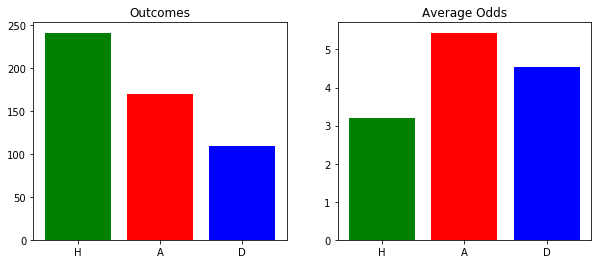

In [8]:
#Have a quick look at the baseline, the distribution of results and the average odds
HDA = y.value_counts(sort = True)
print(y.value_counts(normalize = True, sort = False))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))

ax1.bar(HDA.index, HDA.values, color = ['green', 'r', 'b']);
ax1.set_title('Outcomes')

means = df[['B365H',  'B365A', 'B365D']].mean()
ax2.bar([i[4] for i in  means.index], means.values, color = ['green', 'r', 'b'] );
ax2.set_title('Average Odds')

plt.show()

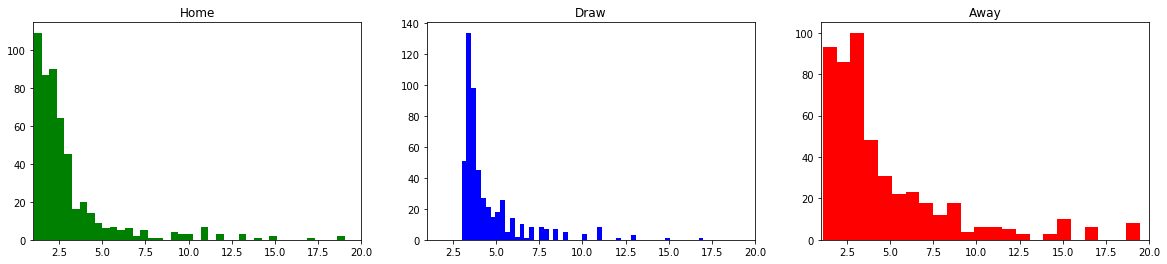

B365H    1.06
B365A    1.12
B365D    3.00
dtype: float64

In [9]:
#are the away team odds really so overlooked when compared to the number of outcomes?
#or are they just being heavily skewed by the long shots - turns out a bit of both
odds = df[['B365H',  'B365A', 'B365D']]

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (20, 4))

ax1.hist(x = odds.B365H.sort_values(), bins = 50, color = 'green');
ax2.hist(x = odds.B365D.sort_values(), bins = 50, color = 'b');
ax3.hist(x = odds.B365A.sort_values(), bins = 50, color = 'r');

ax1.set_xlim(1, 20)
ax2.set_xlim(1, 20)
ax3.set_xlim(1, 20)

ax1.set_title('Home')
ax2.set_title('Draw')
ax3.set_title('Away')

plt.show()

odds.min()

In [10]:
Models = []
CV_scores = []
Test_scores = []
#create lists for later comparison of models

# Now for some Modelling

In [11]:
from sklearn.linear_model import LogisticRegressionCV

### Although shuffling the data produces more accurate results, this project is about predicting the future and so should be evaluatated in as similar conditions as possible; therefore no shuffling

In [12]:
pd.options.mode.chained_assignment = None 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])

scaler =StandardScaler()

cls = LogisticRegressionCV(multi_class = 'ovr',  max_iter = 10000, cv = 5)

param_grid = {'model__Cs': [np.logspace(-3, 3, 20)],
              'model__solver' : ['lbfgs'],
              'decay__last_match': [0.01, 0.025, 0.05],
              'decay__last_3' : [0.08, 0.09, 0.1],
              'decay__last_5': [0, 0.005, 0.01]
             }

pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])


GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)


GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('LogisticRegressionCV')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ',cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train Score: ', model.score(X_train, y_train))
print('Test Score: ', model.score(X_test, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   24.8s finished


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.08, last_5=0, last_match=0.01)),
                ('scaler',
                 Standa...
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                                      class_weight=None, cv=5, dual=False,
                                      fit_intercept=True, intercept_scaling=1.0,
                                      l1_ratios=None, max_iter=10000,
        

In [13]:
model.steps[-1][1].C_

array([1.12883789e+02, 1.00000000e-03, 1.00000000e-03])

In [14]:
model.steps[-1][1].coef_

array([[-9.27704226e-01, -4.94373758e-01, -7.01105830e-01,
        -1.35122820e-01,  1.10528460e+00,  5.54445669e-01,
         5.08745862e-01, -2.09765179e-01,  2.97102952e-01,
        -8.79034597e-02],
       [-6.27043839e-03, -2.99312635e-03, -3.99269123e-03,
        -3.69694465e-03, -8.06034130e-03,  6.98704517e-04,
        -5.53958883e-03, -4.42702415e-03, -5.82298205e-03,
        -2.64300877e-04],
       [ 5.32421726e-02, -3.41390021e-02,  3.91759967e-02,
         4.25938411e-02, -4.13103537e-02,  3.11033124e-02,
        -2.95843265e-02, -2.93007865e-02,  2.02724269e-02,
        -1.75823762e-02]])

In [15]:
np.unique(model.predict_proba(X_train).argmax(axis=1))

array([0, 2])

In [16]:
model.predict_proba(X_train)[:8]

array([[0.11027031, 0.25185652, 0.63787316],
       [0.16242566, 0.24381165, 0.59376269],
       [0.34576018, 0.19368533, 0.46055449],
       [0.53774342, 0.14026295, 0.32199363],
       [0.53116705, 0.14050197, 0.32833097],
       [0.2761308 , 0.21351032, 0.51035887],
       [0.39663324, 0.18005468, 0.42331208],
       [0.47986115, 0.15236181, 0.36777705]])

In [17]:
X_train[:8]

,HomeTeam,AwayTeam,Home_ELO,Home_LP,Home_Points/Played,Home_GD,home_last_match,home_last_3,home_last_5,Away_ELO,...,Away_Points/Played,Away_GD,away_last_match,away_last_3,away_last_5,B365H,B365D,B365A,Home_Decay,Away_Decay
0,Man United,Leicester,1882.255249,1.0,0.0,0.0,0.0,0.0,0.0,1694.578125,...,0.0,0.0,0.0,0.0,0.0,1.57,3.9,7.50,0.0,0.0
1,Bournemouth,Cardiff,1670.799805,1.0,0.0,0.0,0.0,0.0,0.0,1573.711304,...,0.0,0.0,0.0,0.0,0.0,1.90,3.6,4.50,0.0,0.0
2,Fulham,Crystal Palace,1631.047729,1.0,0.0,0.0,0.0,0.0,0.0,1690.268555,...,0.0,0.0,0.0,0.0,0.0,2.50,3.4,3.00,0.0,0.0
3,Huddersfield,Chelsea,1564.291870,1.0,0.0,0.0,0.0,0.0,0.0,1834.489136,...,0.0,0.0,0.0,0.0,0.0,6.50,4.0,1.61,0.0,0.0
4,Newcastle,Tottenham,1668.042847,1.0,0.0,0.0,0.0,0.0,0.0,1912.118164,...,0.0,0.0,0.0,0.0,0.0,3.90,3.5,2.04,0.0,0.0
5,Watford,Brighton,1623.495850,1.0,0.0,0.0,0.0,0.0,0.0,1630.092163,...,0.0,0.0,0.0,0.0,0.0,2.37,3.2,3.40,0.0,0.0
6,Wolves,Everton,1590.322388,1.0,0.0,0.0,0.0,0.0,0.0,1696.834473,...,0.0,0.0,0.0,0.0,0.0,2.37,3.3,3.30,0.0,0.0
7,Arsenal,Man City,1819.932617,1.0,0.0,0.0,0.0,0.0,0.0,1972.182007,...,0.0,0.0,0.0,0.0,0.0,4.00,3.8,1.95,0.0,0.0


In [18]:
import pickle
LRCV_model = model
filename = '../Models/LRCV_model.sav'
pickle.dump(LRCV_model, open(filename, 'wb'))

In [19]:
import pickle
filename = '../Models/LRCV_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5230769230769231


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle =False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])

scaler = StandardScaler()

cls = RandomForestClassifier(criterion = 'gini')

param_grid = {'model__bootstrap': [True],
             'model__max_depth': [ 3, 4, 5],
             'model__max_features': ['auto'],
             'model__min_samples_leaf': [1, 2, 3],
             'model__min_samples_split': [10, 12],
             'model__n_estimators': [10, 12, 14],
              'decay__last_match': [0.01, 0.025, 0.05],
              'decay__last_3' : [0.08, 0.09, 0.1],
              'decay__last_5': [0, 0.005, 0.01]
             }

pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])


GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)




GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('RandomForrest')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed:  4.2min finished


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.1, last_5=0, last_match=0.025)),
                ('scaler',
                 Standa...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min

In [21]:
import pickle
Random_forrest_model = model
filename = '../Models/RF_model.sav'
pickle.dump((Random_forrest_model), open(filename, 'wb'))

In [22]:
filename = '../Models/RF_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.4846153846153846


In [23]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])

scaler = StandardScaler()

cls = svm.SVC(probability=True)

param_grid = {'model__C': np.logspace(-2, 1, 20),
             'model__gamma': [0.001, 0.005, 0.01, 'scale'],
              'decay__last_match': [0.01, 0.025, 0.05],
              'decay__last_3' : [0.08, 0.09, 0.1],
              'decay__last_5': [0, 0.005, 0.01]
             }

pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])


GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)




GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('Support Vector Machine')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))    

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800

Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.08, last_5=0, last_match=0.01)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.005,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                    

In [24]:
import pickle
SVM_model = model
filename = '../Models/SVM_model.sav'
pickle.dump((SVM_model), open(filename, 'wb'))

In [25]:
filename = '../Models/SVM_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.49230769230769234


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])

scaler = StandardScaler()
    
cls = DecisionTreeClassifier()

param_grid = {'model__min_samples_split' : range(80,160,20),
            'model__criterion' : ["gini", "entropy"],
            'model__min_samples_leaf' : range(5, 7),
            'model__min_impurity_split' : [5, 10, None],
            'model__max_depth': range(2, 4),
              'decay__last_match': [0.01, 0.025, 0.05],
              'decay__last_3' : [0.08, 0.09, 0.1],
              'decay__last_5': [0, 0.005, 0.01]
             }

pipe = Pipeline(steps = [('decay', decay),
                        ('sclaer', scaler),
                        ('model', cls)])


GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)



GS.fit(X_train, y_train)

DTC_model = GS.best_estimator_

print(DTC_model)

print(GS.best_score_ )

Models.append('Decision Tree')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(DTC_model, X_train, y_train, cv = 5).mean())
print('Train: ', DTC_model.score(X_train, y_train))
print('Test: ', DTC_model.score(X_test, y_test))

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.08, last_5=0, last_match=0.01)),
                ('sclaer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=2, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                          

[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  6.1min finished


In [27]:
import pickle
DTC_model = DTC_model
filename = '../Models/DTC_model.sav'
pickle.dump((DTC_model), open(filename, 'wb'))

In [28]:
filename = '../Models/DTC_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.47692307692307695


In [29]:
DTC_model.steps[-1][1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=80,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


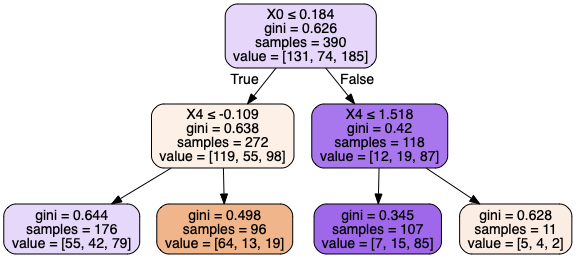

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()

export_graphviz(DTC_model.steps[-1][1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                
               )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1, shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])


scaler = StandardScaler()

cls = AdaBoostClassifier(base_estimator = loaded_model.steps[-1][1])


pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])



param_grid = {"model__base_estimator__criterion" : ["gini", "entropy"],
              "model__base_estimator__splitter" :   ["best", "random"],
              "model__n_estimators": range(1, 10),
              "model__learning_rate": [0.1, 0.5],
              'decay__last_match': [0.01, 0.025, 0.05],
                'decay__last_3' : [0.08, 0.09, 0.1],
                'decay__last_5': [0, 0.005, 0.01]
             }

GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)

GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('Ada Boost Classifier')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  4.4min


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.1, last_5=0.01, last_match=0.01)),
                ('scaler',
                 Stan...
                                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                          criterion='entropy',
                                                                          max_depth=2,
                                                                          max_features=None,
          

[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed:  5.0min finished


In [32]:
import pickle
Ada_model = model
filename = '../Models/AdaBoost_model.sav'
pickle.dump((Ada_model), open(filename, 'wb'))

In [33]:
filename = '../Models/AdaBoost_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.49230769230769234


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1, shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])


scaler = StandardScaler()

cls = AdaBoostClassifier(base_estimator = pickle.load(open('../Models/LRCV_model.sav', 'rb')).steps[-1][1])


pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])



param_grid = {"model__base_estimator__Cs" : [np.logspace(-3, 3, 10)],
              "model__n_estimators": range(1, 10),
              "model__learning_rate": [0.1, 0.5],
              'decay__last_match': [0.01, 0.025, 0.05],
                'decay__last_3' : [0.08, 0.09, 0.1],
                'decay__last_5': [0, 0.005, 0.01]
             }

GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)

GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('Ada Boost LogRegCV')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 14.6min finished


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.08, last_5=0.005, last_match=0.025)),
                ('scaler',
                 S...
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                                                        class_weight=None,
                                                                        cv=5,
                                                                        dual=False,
             

In [35]:
import pickle
AdaLR_model = model
filename = '../Models/AdaBoost_LRCV_model.sav'
pickle.dump((AdaLR_model), open(filename, 'wb'))

In [36]:
filename = '../Models/AdaBoost_LRCV_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1, shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])


scaler = StandardScaler()

cls = GradientBoostingClassifier()

param_grid = {
    "model__learning_rate": [0.1, 0.25],
    "model__min_samples_split": [0.1, 0.25],
    "model__min_samples_leaf": [0.1, 0.25],
    "model__max_depth":[3, 5],
    "model__max_features":["log2"],
    "model__subsample":[0.8, 1.0],
    "model__n_estimators":[2, 3, 4],
    'decay__last_match': [0.01, 0.025, 0.05],
    'decay__last_3' : [0.08, 0.09, 0.1],
    'decay__last_5': [0, 0.005, 0.01]
    }


pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])

GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)



GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('Gradient Boost Tree')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.1, last_5=0, last_match=0.01)),
                ('scaler',
                 Standar...
                                            learning_rate=0.25, loss='deviance',
                                            max_depth=5, max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
              

[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  6.2min finished


In [38]:
import pickle
GBC_model = model
filename = '../Models/GradBoost_model.sav'
pickle.dump((GBC_model), open(filename, 'wb'))

In [39]:
filename = '../Models/GradBoost_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.47692307692307695


In [40]:
from sklearn.neural_network import MLPClassifier

In [41]:
X = df[['HomeTeam', 'AwayTeam',
        'Home_ELO', 'Home_LP', 'Home_Points/Played', 'Home_GD', #'home_decay',
        'home_last_match', 
        'home_last_3', 'home_last_5', 
        'Away_ELO', 'Away_LP', 'Away_Points/Played', 'Away_GD', #'away_decay',
        'away_last_match',
        'away_last_3', 'away_last_5',
        'B365H', 'B365D', 'B365A'
       ]]
y = df.FTR

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1, shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])


scaler = StandardScaler()

cls = MLPClassifier(max_iter=100, early_stopping = True)

pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])


parameter_space = {
    'model__hidden_layer_sizes': [(150, 150, 150), (100, 100, 100)],
    'model__activation': ['tanh', 'relu','identity', 'logistic'],
    'model__solver': ['sgd', 'adam', 'lbfgs'],
    'model__alpha': np.logspace(-8, -6, 5),
    'model__learning_rate': ['constant','adaptive'], 
    'decay__last_match': [0.01, 0.05],
    'decay__last_3' : [0.08],
    'decay__last_5': [0]
}



GS = GridSearchCV(estimator =  pipe,
                  param_grid = parameter_space,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)



GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('Nueral Network')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ', cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train: ', model.score(X_train, y_train))
print('Test: ', model.score(X_test, y_test))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  4.2min finished


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0.08, last_5=0, last_match=0.05)),
                ('scaler',
                 Standa...
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=(100, 100, 100),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=100,
                               momentum=

In [43]:
import pickle
NNet_model = model
filename = '../Models/NNet_model.sav'
pickle.dump((NNet_model), open(filename, 'wb'))

In [44]:
filename = '../Models/NNet_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5153846153846153


In [45]:
pd.options.mode.chained_assignment = None 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 , shuffle = False)

decay = Decay( cols = ['home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'], 
              cols_to_drop = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A' ,
                              'home_last_match', 'home_last_3', 'home_last_5', 
                            'away_last_match', 'away_last_3', 'away_last_5'])

scaler =StandardScaler()

cls = LogisticRegression(multi_class = 'ovr',  max_iter = 10000)

param_grid = {'model__C': np.logspace(-3, 3, 100),
              'model__solver' : ['lbfgs'],
              'decay__last_match': [0],
              'decay__last_3' : [0],
              'decay__last_5': [0]
             }

pipe = Pipeline(steps = [('decay', decay),
                        ('scaler', scaler),
                        ('model', cls)])


GS = GridSearchCV(estimator =  pipe,
                  param_grid = param_grid,
                  n_jobs = -1, verbose = 1, cv =5 , iid = False)


GS.fit(X_train, y_train)

model = GS.best_estimator_

print(model)

print(GS.best_score_ )

Models.append('LogisticRegression')
CV_scores.append(GS.best_score_)
Test_scores.append(GS.best_estimator_.score(X_test, y_test))


print('CV Score: ',cross_val_score(model, X_train, y_train, cv = 5).mean())
print('Train Score: ', model.score(X_train, y_train))
print('Test Score: ', model.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s


Pipeline(memory=None,
         steps=[('decay',
                 Decay(cols=['home_last_match', 'home_last_3', 'home_last_5',
                             'away_last_match', 'away_last_3', 'away_last_5'],
                       cols_to_drop=['HomeTeam', 'AwayTeam', 'B365H', 'B365D',
                                     'B365A', 'home_last_match', 'home_last_3',
                                     'home_last_5', 'away_last_match',
                                     'away_last_3', 'away_last_5'],
                       last_3=0, last_5=0, last_match=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=0.9326033468832199, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=10000, multi_class='ovr',
                     

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.2s finished


In [46]:
import pickle
LR_model = model
filename = '../Models/LR_model.sav'
pickle.dump((LR_model), open(filename, 'wb'))

In [47]:
filename = '../Models/LR_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5153846153846153


In [48]:
Models

['LogisticRegressionCV',
 'RandomForrest',
 'Support Vector Machine',
 'Decision Tree',
 'Ada Boost Classifier',
 'Ada Boost LogRegCV',
 'Gradient Boost Tree',
 'Nueral Network',
 'LogisticRegression']

In [49]:
CV_scores

[0.6050013277861379,
 0.5998406656634505,
 0.5922465719934075,
 0.5794252161340769,
 0.5973773062380657,
 0.6100979189586785,
 0.5974089201937304,
 0.5944835754962338,
 0.5998739656967506]

In [50]:
Test_scores

[0.5230769230769231,
 0.4846153846153846,
 0.49230769230769234,
 0.47692307692307695,
 0.49230769230769234,
 0.5,
 0.47692307692307695,
 0.5153846153846153,
 0.5153846153846153]

In [51]:
results_df = pd.DataFrame({
    'Model' : Models,
    'CV' : CV_scores,
    'Test': Test_scores
})

In [52]:
results_df.set_index('Model', drop = True, inplace = True)

In [53]:
results_df.head(10)

,CV,Test
Model,,
LogisticRegressionCV,0.605001,0.523077
RandomForrest,0.599841,0.484615
Support Vector Machine,0.592247,0.492308
Decision Tree,0.579425,0.476923
Ada Boost Classifier,0.597377,0.492308
Ada Boost LogRegCV,0.610098,0.500000
Gradient Boost Tree,0.597409,0.476923
Nueral Network,0.594484,0.515385
LogisticRegression,0.599874,0.515385


In [54]:
results = results_df.to_csv('../CSV/results_df.csv', index=True)